<a href="https://colab.research.google.com/github/aagamj/Stocks/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance
!pip install mplfinance

     |████████████████████████████████| 6.3 MB 8.0 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=56eb190754bf311c60a44fe364739b5343fa11fdb8c1a4c4e04620449ac22d67
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
     |████████████████████████████████| 62 kB 829 kB/s 


In [34]:
import yfinance as yf
import pandas as pd
import numpy as np
import math
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt

[*********************100%***********************]  1 of 1 completed


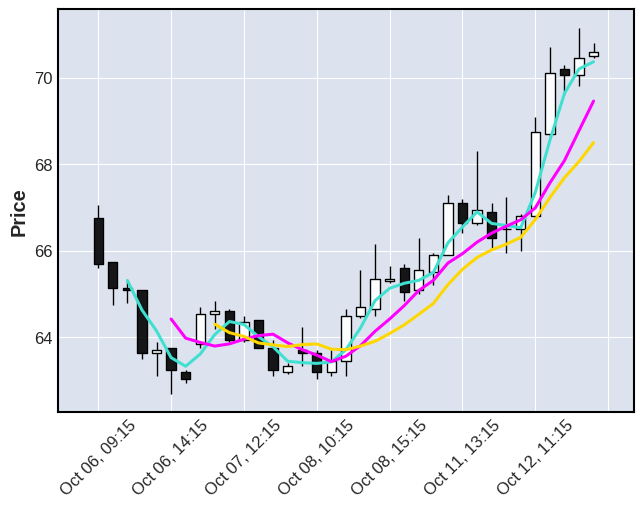

In [35]:
data = yf.download(tickers='bhel.NS', period='5d', interval='1h')
mpf.plot(data,type='candle',mav = (3,6,9))

In [36]:
# get stock prices using yfinance library
def get_stock_price(symbol):
  df = yf.download(symbol, start='2021-02-01',interval = '1d', volume = True,mav = (3,6,9), threads= False)
  df['Date'] = pd.to_datetime(df.index)
  df['Date'] = df['Date'].apply(mpl_dates.date2num)
  df = df.loc[:,['Date', 'Open', 'High', 'Low', 'Close']]
  return df
  
  symbol = 'BHEL.NS'


In [37]:
#method 1: fractal candlestick pattern
# determine bullish fractal 
def is_support(df,i):  
  cond1 = df['Low'][i] < df['Low'][i-1]   
  cond2 = df['Low'][i] < df['Low'][i+1]   
  cond3 = df['Low'][i+1] < df['Low'][i+2]   
  cond4 = df['Low'][i-1] < df['Low'][i-2]  
  return (cond1 and cond2 and cond3 and cond4) # determine bearish fractal
def is_resistance(df,i):  
  cond1 = df['High'][i] > df['High'][i-1]   
  cond2 = df['High'][i] > df['High'][i+1]   
  cond3 = df['High'][i+1] > df['High'][i+2]   
  cond4 = df['High'][i-1] > df['High'][i-2]  
  return (cond1 and cond2 and cond3 and cond4)# to make sure the new level area does not exist already
def is_far_from_level(value, levels, df):    
  ave =  np.mean(df['High'] - df['Low'])    
  return np.sum([abs(value-level)<ave for _,level in levels])==0# a list to store resistance and support levels
levels = []
for i in range(2, df.shape[0] - 2):  
  if is_support(df, i):    
    low = df['Low'][i]    
    if is_far_from_level(low, levels, df):      
      levels.append((i, low))  
  elif is_resistance(df, i):    
    high = df['High'][i]    
    if is_far_from_level(high, levels, df):      
      levels.append((i, high))

In [38]:
#Visualization
def plot_all(levels, df):    
  fig, ax = plt.subplots(figsize=(16, 9))   
  candlestick_ohlc(ax,df.values,width=0.6, colorup='green', 
    colordown='red', alpha=0.8)    
  date_format = mpl_dates.DateFormatter('%d %b %Y')
  ax.xaxis.set_major_formatter(date_format)    
  for level in levels:        
    plt.hlines(level[1], xmin = df['Date'][level[0]], xmax = 
      max(df['Date']), colors='blue', linestyle='--')    
  fig.show()

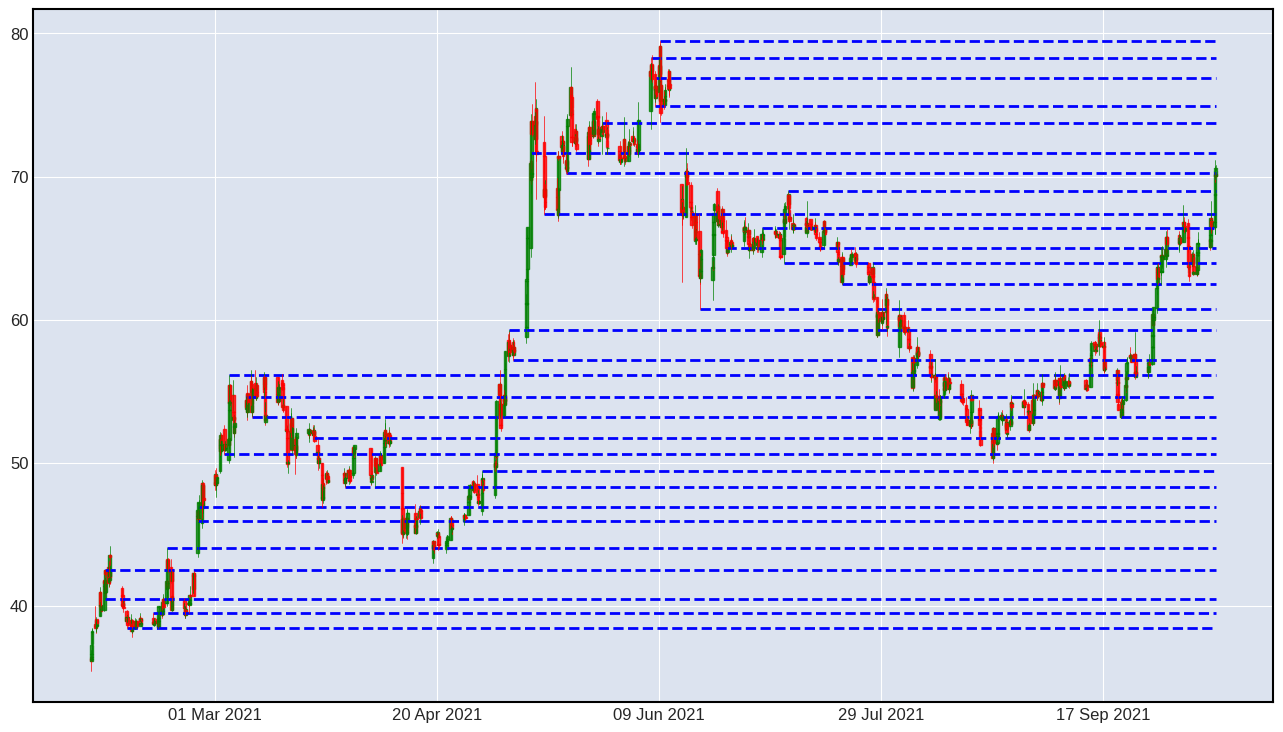

In [39]:
plot_all(levels,df)

[*********************100%***********************]  1 of 1 completed


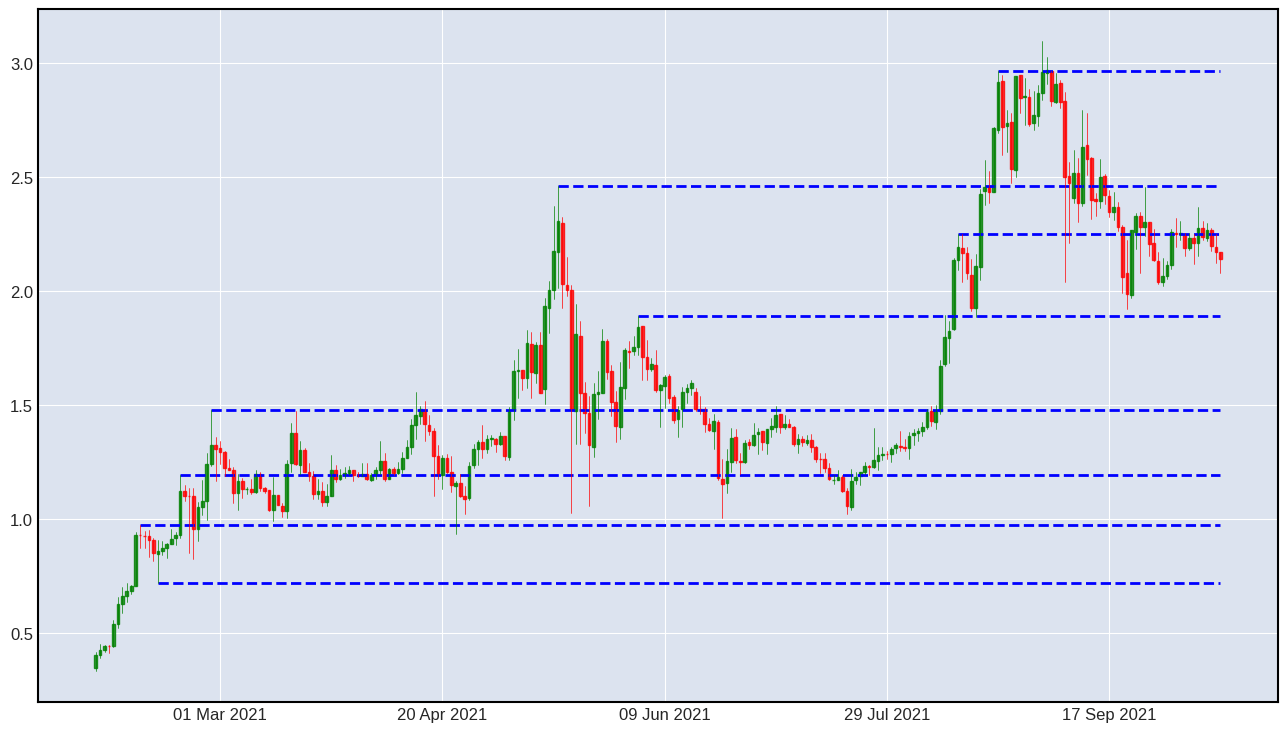

In [41]:
#method 2: window shifting method
#using the same symbol as the first example above
symbol = 'ADA-USD'
df = get_stock_price(symbol)
pivots = []
max_list = []
min_list = []
for i in range(5, len(df)-5):
  # taking a window of 9 candles
  high_range = df['High'][i-5:i+4]
  current_max = high_range.max()
  # if we find a new maximum value, empty the max_list 
  if current_max not in max_list:
    max_list = []
  max_list.append(current_max)
  # if the maximum value remains the same after shifting 5 times
  if len(max_list)==5 and is_far_from_level(current_max,pivots,df):
      pivots.append((high_range.idxmax(), current_max))
    
  low_range = df['Low'][i-5:i+5]
  current_min = low_range.min()
  if current_min not in min_list:
    min_list = []
  min_list.append(current_min)
  if len(min_list)==5 and is_far_from_level(current_min,pivots,df):
    pivots.append((low_range.idxmin(), current_min))
plot_all(pivots, df)